In [8]:
# Import necessary libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Record start time to track execution time
import time
start_time = time.time()

print("Environment setup complete!")

Environment setup complete!


In [9]:
import urllib.request
import os
import gzip
import shutil

# Create data directory
os.makedirs('../data', exist_ok=True)

# Download Facebook network dataset
url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
output_path = '../data/facebook_combined.txt.gz'

print(f"Download the dataset from {url}...")
urllib.request.urlretrieve(url, output_path)
print(f"The dataset has been saved to {output_path}")

# Unzip
with gzip.open(output_path, 'rb') as f_in:
    with open('../data/facebook_combined.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("The dataset has been extracted")

Download the dataset from https://snap.stanford.edu/data/facebook_combined.txt.gz...
The dataset has been saved to ../data/facebook_combined.txt.gz
The dataset has been extracted


In [10]:
# Read the network data
edges = pd.read_csv('../data/facebook_combined.txt', sep=' ', header=None, names=['source', 'target'])
print("Data preview:")
print(edges.head())

# Check the dataset size
print(f"The dataset contains {len(edges)} edges")

# Build the network
G = nx.from_pandas_edgelist(edges, 'source', 'target')
print(f"Created a network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Data preview:
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5
The dataset contains 88234 edges
Created a network with 4039 nodes and 88234 edges


C:\Users\Shengyao\AppData\Local\Temp\ipykernel_145940\2462235054.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


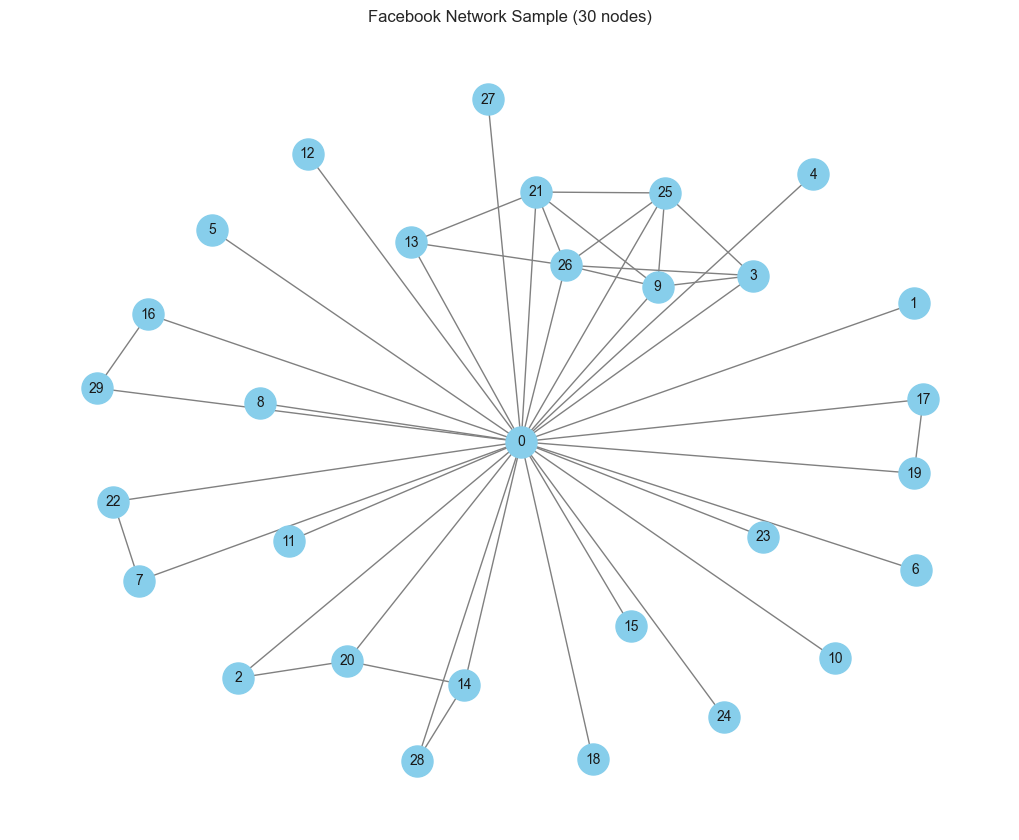

In [11]:
# Select the subgraph of first 30 nodes
sub_nodes = list(G.nodes())[:30]
subgraph = G.subgraph(sub_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', 
        node_size=500, edge_color='gray', font_size=10)
plt.title("Facebook Network Sample (30 nodes)")
plt.tight_layout()
plt.show()

In [12]:
# Extract features
def extract_node_features(G):
    """Extract network node features"""
    features = {}
    
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(G)
    
    print("Calculating clustering coefficient...")
    clustering = nx.clustering(G)
    
    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # If the network is too large skip this part
    if G.number_of_nodes() < 1000:
        print("Calculating betweenness centrality...")
        betweenness_centrality = nx.betweenness_centrality(G)
    else:
        print("Network too large, skipping betweenness centrality calculation...")
        betweenness_centrality = {node: 0 for node in G.nodes()}
    
    # Combine features
    nodes = list(G.nodes())
    feature_df = pd.DataFrame({
        'node': nodes,
        'degree_centrality': [degree_centrality[n] for n in nodes],
        'clustering': [clustering[n] for n in nodes],
        'pagerank': [pagerank[n] for n in nodes],
        'betweenness_centrality': [betweenness_centrality[n] for n in nodes]
    })
    
    return feature_df

# Extract features
node_features = extract_node_features(G)

# Display first few rows
print("\nNode features preview:")
print(node_features.head())

# View basic statistics of features
print("\nFeature statistics:")
print(node_features.describe())


Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Network too large, skipping betweenness centrality calculation...

Node features preview:
   node  degree_centrality  clustering  pagerank  betweenness_centrality
0     0           0.085934    0.041962  0.006290                       0
1     1           0.004210    0.419118  0.000236                       0
2     2           0.002476    0.888889  0.000203                       0
3     3           0.004210    0.632353  0.000226                       0
4     4           0.002476    0.866667  0.000238                       0

Feature statistics:
              node  degree_centrality   clustering     pagerank  \
count  4039.000000        4039.000000  4039.000000  4039.000000   
mean   2019.000000           0.010820     0.605547     0.000248   
std    1166.103197           0.012982     0.214462     0.000259   
min       0.000000           0.000248     0.000000     0.000042   
25%    1009.500000   

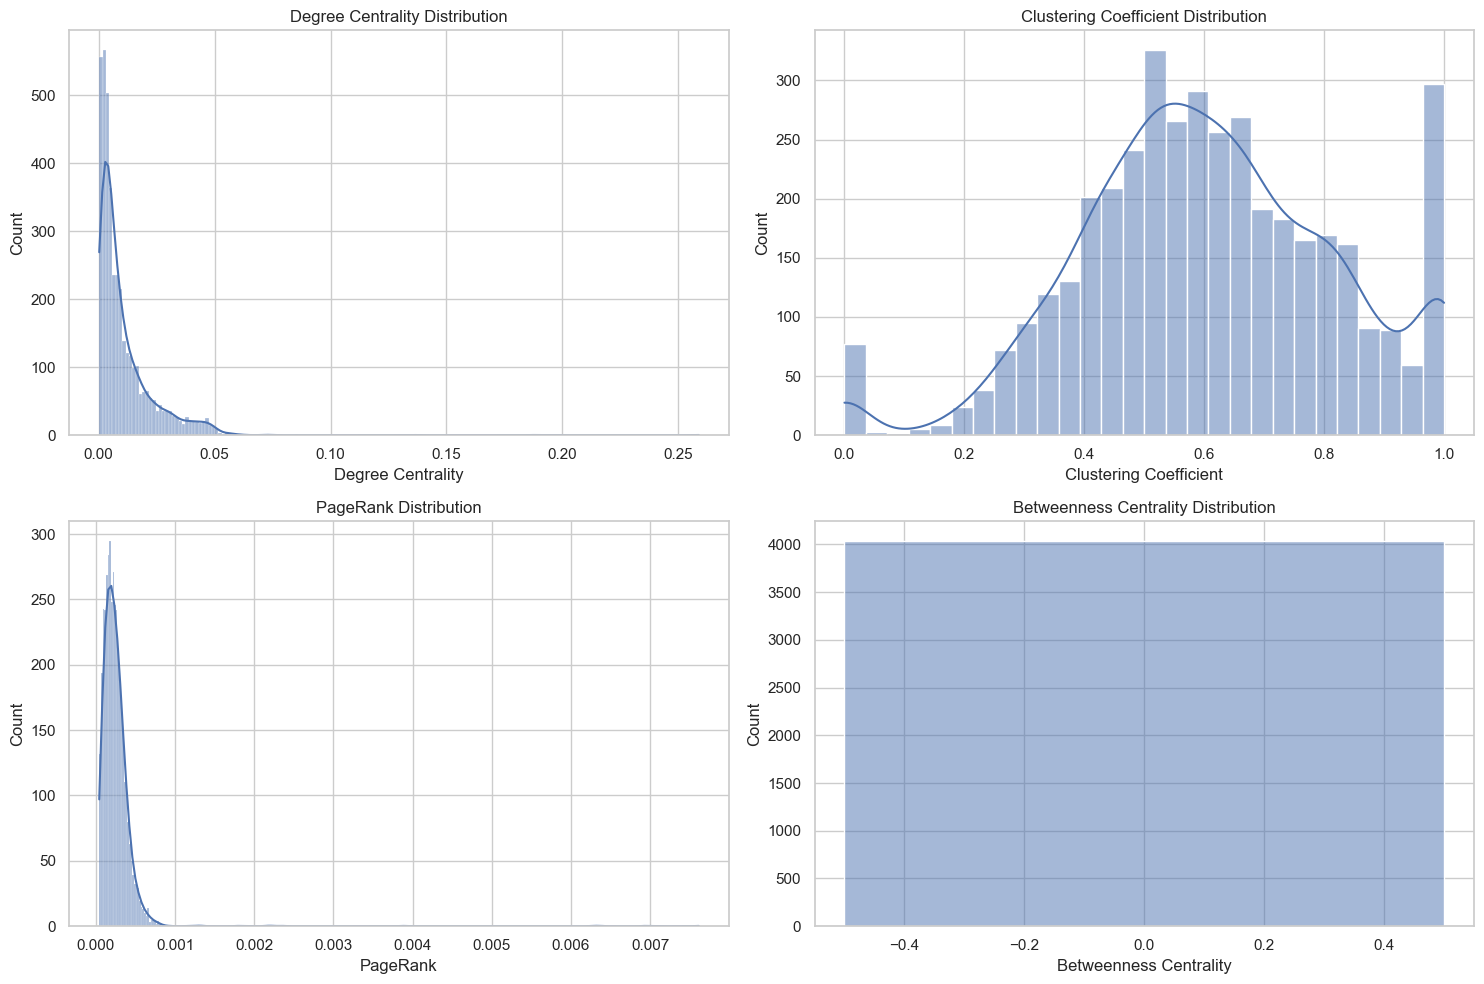

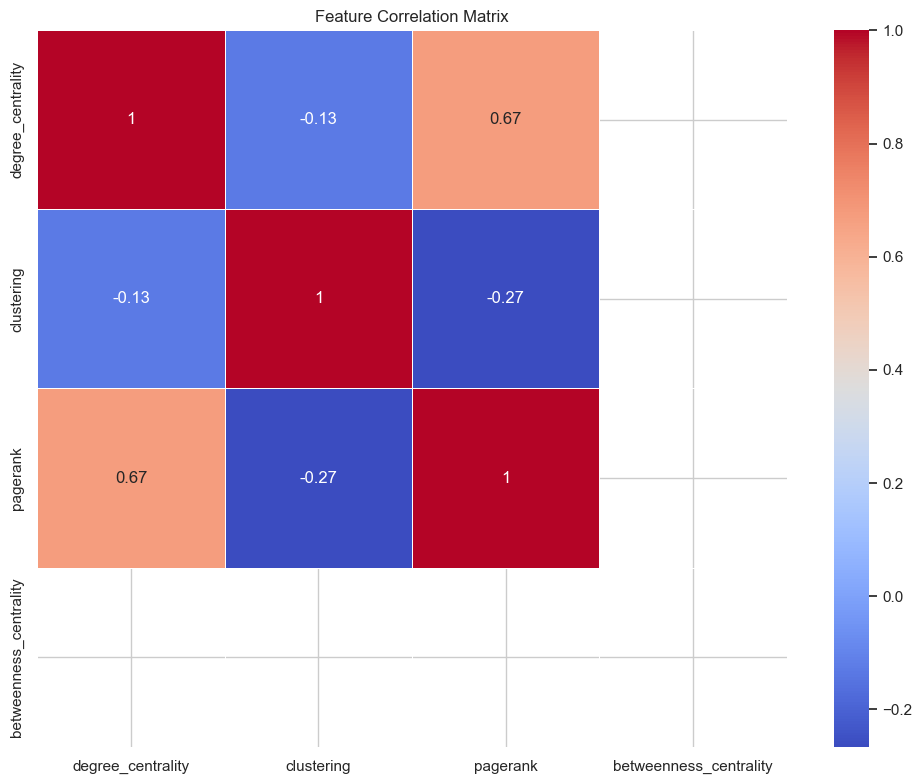

In [13]:
# Visualize feature distributions
plt.figure(figsize=(15, 10))

# Degree centrality distribution
plt.subplot(2, 2, 1)
sns.histplot(node_features['degree_centrality'], kde=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')

# Clustering coefficient distribution
plt.subplot(2, 2, 2)
sns.histplot(node_features['clustering'], kde=True)
plt.title('Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')

# PageRank distribution
plt.subplot(2, 2, 3)
sns.histplot(node_features['pagerank'], kde=True)
plt.title('PageRank Distribution')
plt.xlabel('PageRank')

# Betweenness centrality distribution
plt.subplot(2, 2, 4)
sns.histplot(node_features['betweenness_centrality'], kde=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

plt.tight_layout()
plt.show()

# Create a feature correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = node_features.drop('node', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Anomaly detection
def detect_anomalies(feature_df, method='isolation_forest', contamination=0.05):
    """
    Detect anomalies using machine learning methods
    
    Parameters:
    feature_df - DataFrame containing node features
    method - Anomaly detection method to use
    contamination - Expected proportion of anomalies
    
    Returns:
    DataFrame with anomaly labels
    """
    # Select feature columns
    feature_columns = [col for col in feature_df.columns if col != 'node']
    features = feature_df[feature_columns].values
    
    # Standardize features
    print("Standardizing features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Perform anomaly detection
    print(f"Performing anomaly detection using {method}...")
    if method == 'isolation_forest':
        clf = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
        # Anomaly prediction: -1 for anomaly, 1 for normal
        labels = clf.fit_predict(scaled_features)
    
    # Add anomaly labels to the DataFrame
    result_df = feature_df.copy()
    result_df['anomaly'] = [1 if x == -1 else 0 for x in labels]
    
    # Display
    anomaly_count = result_df['anomaly'].sum()
    total_count = len(result_df)
    print(f"Detected {anomaly_count} anomaly nodes, accounting for {anomaly_count/total_count:.2%} of total nodes")
    
    return result_df

# Run anomaly detection
anomaly_results = detect_anomalies(node_features, contamination=0.05)

# View features of anomalous nodes
print("\nAnomalous node features:")
print(anomaly_results[anomaly_results['anomaly'] == 1].head())


Standardizing features...
Performing anomaly detection using isolation_forest...
Detected 202 anomaly nodes, accounting for 5.00% of total nodes

Anomalous node features:
    node  degree_centrality  clustering  pagerank  betweenness_centrality  \
0      0           0.085934    0.041962  0.006290                       0   
11    11           0.000248    0.000000  0.000053                       0   
12    12           0.000248    0.000000  0.000053                       0   
15    15           0.000248    0.000000  0.000053                       0   
18    18           0.000248    0.000000  0.000053                       0   

    anomaly  
0         1  
11        1  
12        1  
15        1  
18        1  


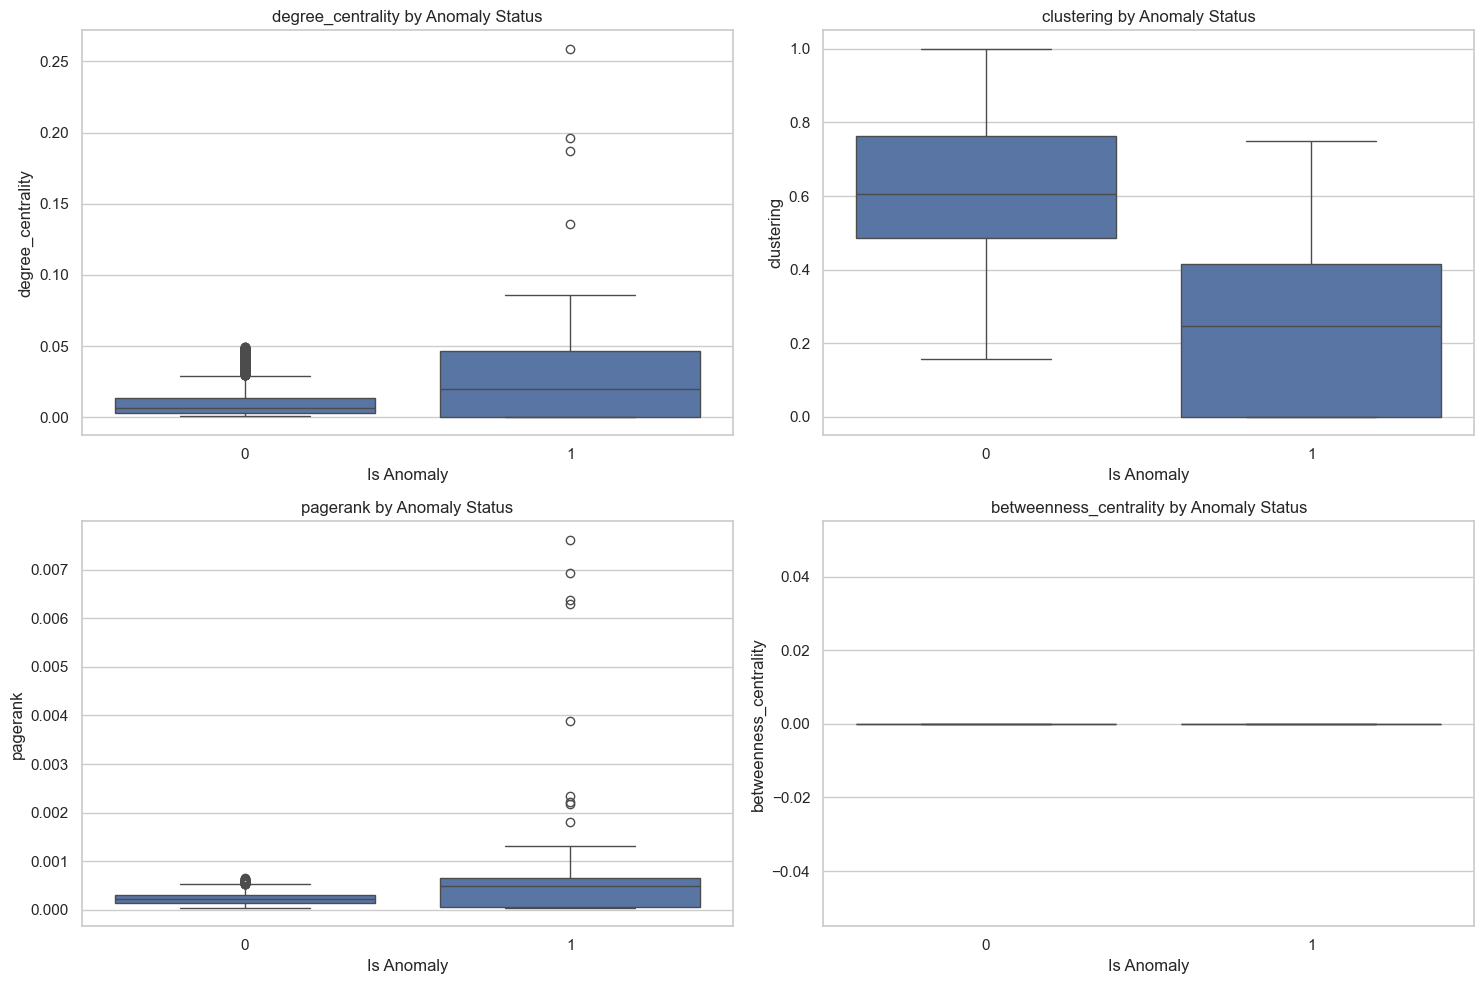

C:\Users\Shengyao\AppData\Local\Temp\ipykernel_145940\4010528066.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


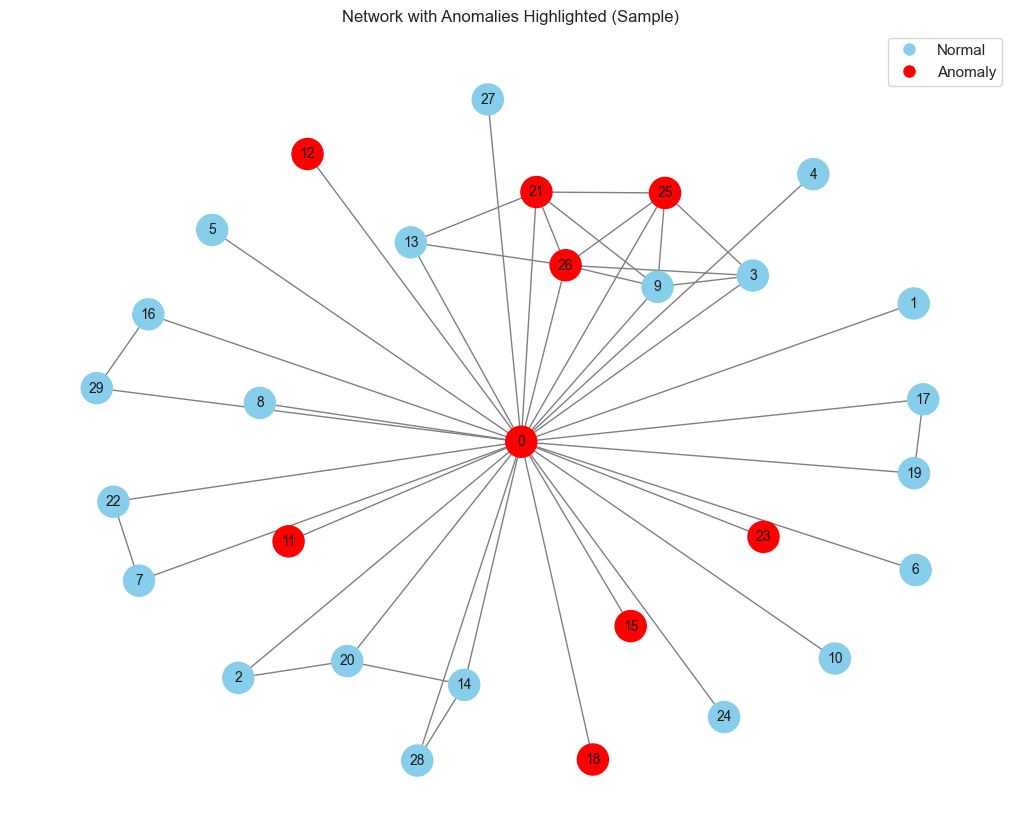

In [15]:
# Create box plots comparing features of anomalous and normal nodes
plt.figure(figsize=(15, 10))

features_to_plot = ['degree_centrality', 'clustering', 'pagerank', 'betweenness_centrality']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='anomaly', y=feature, data=anomaly_results)
    plt.title(f'{feature} by Anomaly Status')
    plt.xlabel('Is Anomaly')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Use the subgraph of 30 nodes for demonstration
sub_nodes = list(G.nodes())[:30]
subgraph = G.subgraph(sub_nodes)

# Get anomaly labels
sub_node_anomalies = anomaly_results[anomaly_results['node'].isin(sub_nodes)]
node_colors = ['red' if row['anomaly'] == 1 else 'skyblue' 
               for _, row in sub_node_anomalies.iterrows()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, 
        node_size=500, edge_color='gray', font_size=10)
plt.title("Network with Anomalies Highlighted (Sample)")

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', 
                         markersize=10, label='Normal'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=10, label='Anomaly')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [16]:
# Save anomaly detection to CSV file
result_path = '../results/anomaly_detection_results.csv'
anomaly_results.to_csv(result_path, index=False)
print(f"Anomaly detection results have been saved to {result_path}")

# Save the list of anomalous nodes
anomaly_nodes = anomaly_results[anomaly_results['anomaly'] == 1]['node'].tolist()
with open('../results/anomaly_nodes.txt', 'w') as f:
    f.write('\n'.join(map(str, anomaly_nodes)))
print("Anomalous node list has been saved to ../results/anomaly_nodes.txt")

Anomaly detection results have been saved to ../results/anomaly_detection_results.csv
Anomalous node list has been saved to ../results/anomaly_nodes.txt
